# Concolic Fuzzing

We have previously seen how one can use dynamic taints to produce more intelligent test cases than simply looking for program crashes. We have also seen how one can use the taints to update the grammar, and hence focus more on the dangerous methods. 

While taints are helpful, uninterpreted strings is only one of the attack vectors. Can we say anything more about the properties of variables at any point in the execution? For example, can we say for sure that a function will always receive the buffers with the correct length? Concolic execution offers a solution. With concolic execution, one can collect the constraints that an execution path encounters, and use it to answer questions about the program behavior at any point we prefer. We can even use concolic execution to enhance fuzzing.

In this chapter, we explore in depth how to execute a Python function concolically, and how concolic execution can be used to enhance fuzzing.

**Prerequisites**

* You should have read the [chapter on coverage](Coverage.ipynb).
* You should have read the [chapter on information flow](InformationFlow.ipynb).
* A familiarity with the basic idea of [SMT solvers](https://en.wikipedia.org/wiki/Satisfiability_modulo_theories) would be useful.

We first setup our infrastructure so that we can make use of previously defined functions.

In [1]:
import fuzzingbook_utils

## Tracking Constraints

In the chapter on [information flow](InformationFlow), we have seen how dynamic taints can be used to direct fuzzing by indicating which part of input reached interesting places. However, dynamic taint tracking is limited in the information that it can propagate. For example, we might want to explore what happens when certain properties of the input changes.

For example, say we have a function `factorial()` that returns the *factorial value* of its input.

In [2]:
def factorial(n):
    if n < 0:
        return None
    if n == 0:
        return 1
    if n == 1:
        return 1
    v = 1
    while n != 0:
        v = v * n
        n = n - 1
    return v

We exercise the function with a value of `5`.

In [3]:
factorial(5)

120

Is this sufficient to explore all the features of the function? How do we know? One way to verify that we have explored all features is to look at the coverage obtained. First we need to extend the `Coverage` class from the [chapter on coverage](Coverage.ipynb) to provide us with coverage arcs.

In [4]:
from Coverage import Coverage

In [5]:
import inspect

In [6]:
class ArcCoverage(Coverage):
    def traceit(self, frame, event, args):
        if event != 'return':
            f = inspect.getframeinfo(frame)
            self._trace.append((f.function, f.lineno))
        return self.traceit

    def arcs(self):
        t = [i for f, i in self._trace]
        return list(zip(t, t[1:]))

Next, we use the `Tracer` to obtain the coverage arcs.

In [7]:
with ArcCoverage() as cov:
    factorial(5)

We can now use the coverage arcs to visualize the coverage obtained.

In [8]:
from ControlFlow import PyCFG, CFGNode, to_graph, gen_cfg

In [9]:
from graphviz import Source, Graph

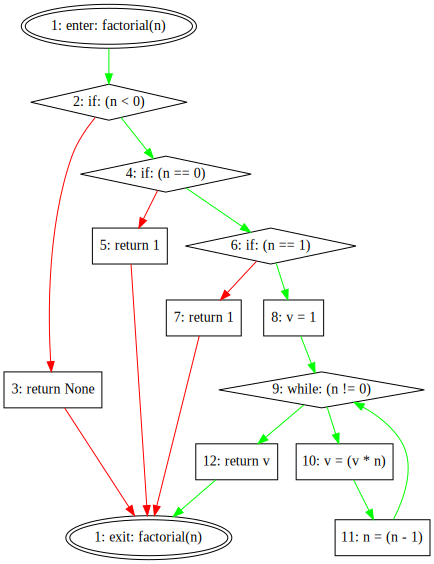

In [10]:
Source(to_graph(gen_cfg(inspect.getsource(factorial)), arcs=cov.arcs()))

We see that the path `[1, 2, 4, 6, 8, 9, 10, 11, 12]` is covered but sub-paths such as  `[2, 3]`,  `[4, 5]` and `[6, 7]` are unexplored. What we need is the ability to generate inputs such that the `True` branch is taken at `2`. How do we do that?

## Concolic Execution

One way is to look at the execution path being taken, and collect the conditional constraints that the path encounters. Then we can try to produce inputs that lead us to taking the non-traversed path.

First, let us step through the function.

In [11]:
lines = [i[1] for i in cov._trace if i[0] == 'factorial']
src = {i+1:s for i,s in enumerate(inspect.getsource(factorial).split('\n'))}

* The line (1) is simply the entry point of the function. We know that the input is `n`, which is an integer.

In [12]:
src[1]

'def factorial(n):'

* The line (2) is a predicate `n < 0`. Since the next line taken is line (4), we know that at this point in the execution path, the predicate was `true`.

In [13]:
src[2], src[3], src[4]

('    if n < 0:', '        return None', '    if n == 0:')

We notice that this is one of the predicates where the `true` branch was not taken. How do we generate a value that takes the `true` branch here? One way is to use symbolic variables to represent the input, encode the constraint, and use an *SMT Solver* to solve the negation of the constraint.

A symbolic variable can be thought of as a sort of placeholder for the real variable, sort of like the `x` in solving for `x` in Algebra. We identify what constraints the variable is supposed to obey, and finally produce a value that obeys all constraints imposed.

We first import an SMT solver, *Z3*.

In [14]:
import z3

We also need to make sure that the latest `z3str3` solver is used, and the timeout is 30 seconds.

In [15]:
z3.get_version()  # should be 4.8.5
z3.set_option('smt.string_solver', 'z3str3')
z3.set_option('timeout', 30 * 1000)  # milliseconds

Encoding the constraint requires declaring a corresponding symbolic variable to the input `n`.

In [16]:
zn = z3.Int('n')

We can now encode the constraint as follows.

In [17]:
zn < 0

n < 0

We use *Z3* to verify that the input `5` would actually result in negation of this constraint.

In [18]:
z3.solve(z3.And(z3.Not(zn < 0), zn == 5))

[n = 5]


Similarly, we can ask *Z3* for an input that satisfies the constraint.

In [19]:
z3.solve(zn < 0)

[n = -1]


Let us try using that with our coverage.

In [20]:
with cov as cov:
    factorial(-1)

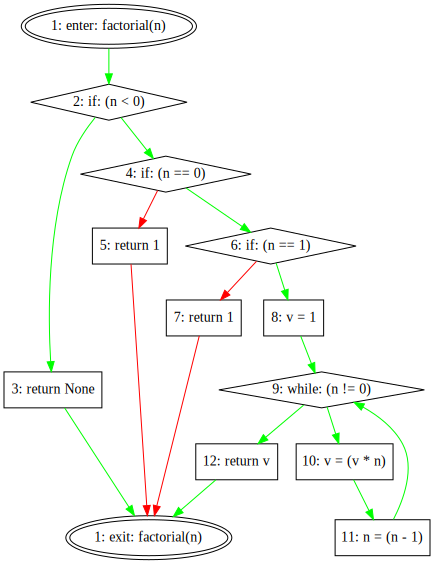

In [21]:
Source(to_graph(gen_cfg(inspect.getsource(factorial)), arcs=cov.arcs()))

Ok, so we have managed to cover a little more of the graph. Let us continue with our original input of `factorial(5)`:
* In line (4) we encounter a new predicate `n == 0`, for which we again took the false branch.

In [22]:
src[4]

'    if n == 0:'

The predicates required to follow the path until this point is as follows.

In [23]:
predicates = [z3.Not(zn < 0), z3.Not(zn == 0)]

* If we continue to line (6), we encounter another predicate, for which again, we took the `false` branch

In [24]:
src[6]

'    if n == 1:'

The predicates encountered so far is as follows

In [25]:
predicates = [z3.Not(zn < 0), z3.Not(zn == 0), z3.Not(zn == 1)]

To take the branch at (6), we essentially have to obey the predicates until that point, but invert the last predicate.

In [26]:
last = len(predicates) - 1
z3.solve(predicates[0:-1] + [z3.Not(predicates[-1])])

[n = 1]


What we are doing here is tracing the execution corresponding to a particular input `factorial(5)`, using concrete values, and along with it, keeping *symbolic shadow variables* that enable us to capture the constraints. This particular method of execution where one combines concrete and symbolic execution is called *Concolic Execution*.

How do we automate this process? One method is to use a similar infrastructure as that of the chapter on [information flow](InformationFlow.ipynb), and use the Python inheritance to create symbolic proxy objects that can track the concrete execution.

### Concolic Tracer

Given that there is a symbolic context under which the program is executed (that is the symbolic variables that are used in the program execution) we define a context manager called `ConcolicTracer` that keeps track of the context.

The `ConcolicTracer` accepts a single argument which contains the declarations for the symbolic variables seen so far, and the pre-conditions if any.

In [27]:
class ConcolicTracer:
    def __init__(self, context=None):
        self.context = context if context is not None else ({}, [])
        self.decls, self.path = self.context

We add the `enter` and `exit` methods for the context manager.

In [28]:
class ConcolicTracer(ConcolicTracer):
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, tb):
        return

We use introspection to determine the arguments to the function, which is hooked into the `getitem` method.

In [29]:
class ConcolicTracer(ConcolicTracer):
    def __getitem__(self, fn):
        self.fn = fn
        self.fn_args = {i: None for i in inspect.signature(fn).parameters}
        return self

Finally, the function itself is invoked using the `call` method.

In [30]:
class ConcolicTracer(ConcolicTracer):
    def __call__(self, *args):
        self.result = self.fn(*self.concolic(args))
        return self.result

For now, we define `concolic()` as a transparent function. It will be modified to produce symbolic variables later.

In [31]:
class ConcolicTracer(ConcolicTracer):
    def concolic(self, args):
        return args

It can be used as follows

In [32]:
with ConcolicTracer() as _:
    _[factorial](1)

In [33]:
_.context

({}, [])

### Concolic Proxy Objects

We now define the concolic proxy objects that can be used for concolic tracing. First, we define the `zproxy_create()` method that given a class name, correctly creates an instance of that class, and the symbolic corresponding variable, and registers the symbolic variable in the context information `context`.

In [34]:
def zproxy_create(cls, sname, z3var, context, zn, v=None):
    zv = cls(context, z3var(zn), v)
    context[0][zn] = sname
    return zv

#### zbool

First, we define the `zbool` class which is used to track the predicates encountered. It is a wrapper class that contains both symbolic (`z`) as well as concrete (`v`) values. The concrete value is used to determine which path to take, and the symbolic value is used to collect the predicates encountered.

The initialization done in two parts. The first one is using `zproxy_create()` to correctly initialize and register the shadow symbolic variable corresponding to the passed argument. This is used exclusively when the symbolic variable needs to be initialized first. In all other cases, the constructor is called with the preexisting symbolic value.

In [35]:
class zbool:
    @classmethod
    def create(cls, context, zn, v):
        return zproxy_create(cls, 'Bool', z3.Bool, context, zn, v)

    def __init__(self, context, z, v=None):
        self.context, self.z, self.v = context, z, v
        self.decl, self.path = self.context

Here is how it can be used.

In [36]:
with ConcolicTracer() as _:
    za, zb = z3.Ints('a b')
    val = zbool.create(_.context, 'my_bool_arg', True)
    print(val.z, val.v)
_.context

my_bool_arg True


({'my_bool_arg': 'Bool'}, [])

##### not
The `zbool` class allows negation of its concrete and symbolic values.

In [37]:
class zbool(zbool):
    def __not__(self):
        return zbool(self.context, z3.Not(self.z), not self.v)

Here is how it can be used.

In [38]:
with ConcolicTracer() as _:
    val = zbool.create(_.context, 'my_bool_arg', True).__not__()
    print(val.z, val.v)
_.context

Not(my_bool_arg) False


({'my_bool_arg': 'Bool'}, [])

##### bool

The `zbool` class is be used to track boolean conditions that arise during program execution. It tracks such conditions by registering the corresponding symbolic expressions in the context.

In [39]:
class zbool(zbool):
    def __bool__(self):
        r, pred = (True, self.z) if self.v else (False, z3.Not(self.z))
        self.path.append(pred)
        return r

The `zbool` class can be used to keep track of boolean values and conditions encountered during the execution as below.

In [40]:
with ConcolicTracer() as _:
    za, zb, zc = z3.Ints('a b c')
    ca, cb, cc = 1, 1, 2
    if zbool(_.context, za == zb, ca == cb):
        if zbool(_.context, zb == zc, cb == cc):
            print('equilateral')
        else:
            print('isosceles')

isosceles


We can retrieve the predicates encountered as follows.

In [41]:
z3.And(_.path).sexpr()

'(and (= a b) (not (= b c)))'

#### zint

Next, we define a symbolic wrapper `zint` for `int`.
This class keeps track of the int variables used and the predicates encountered in `context`. Finally, it also keeps the concrete value used so that it can be used to determine the path to take. As the `zint` extends the primitive `int` class, we have to define a _new_ method to open it for extension.

In [42]:
class zint(int):
    def __new__(cls, context, zn, v, *args, **kw):
        return int.__new__(cls, v, *args, **kw)

As in the case of `zbool`, the initialization takes place in two parts. The first using `create()` if a new symbolic argument is being registered, and then the usual initialization.

In [43]:
class zint(zint):
    @classmethod
    def create(cls, context, zn, v=None):
        return zproxy_create(cls, 'Int', z3.Int, context, zn, v)
    
    def __init__(self, context, z, v=None):
        self.z, self.v = z, v
        self.context = context

Using these proxies are as follows.

In [44]:
with ConcolicTracer() as _:
    val = zint.create(_.context, 'int_arg', 0)
    print(val.z, val.v)
_.context

int_arg 0


({'int_arg': 'Int'}, [])

The `zint` class is often used to do arithmetic with, or compare to other `int`s. These `int`s can be either a variable or a constant value. We define a helper method `_zv()` that checks what kind of `int` a given value is, and produces the correct symbolic equivalent.

In [45]:
class zint(zint):
    def _zv(self, o):
        return (o.z, o.v) if isinstance(o, zint) else (z3.IntVal(o), o)

It can be used as follows

In [46]:
with ConcolicTracer() as _:
    val = zint.create(_.context, 'int_arg', 0)
    print(val._zv(0))
    print(val._zv(val))

(0, 0)
(int_arg, 0)


##### equality

Two integers can be compared for equality using _ne_ and _eq_.

In [47]:
class zint(zint):
    def __ne__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z != z, self.v != v)

    def __eq__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z == z, self.v == v)

 We also define _req_ using _eq_ in case the int being compared is on the left hand side.

In [48]:
class zint(zint):
    def __req__(self, other):
        return self.__eq__(other)

It can be used as follows.

In [49]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    ib = zint.create(_.context, 'int_b', 0)
    v1 = ia == ib
    v2 = ia != ib
    v3 = 0 != ib
    print(v1.z, v2.z, v3.z)

int_a == int_b int_a != int_b 0 != int_b


##### comparisons

Integers can also be compared for ordering, and the methods for this are defined below.

In [50]:
class zint(zint):
    def __lt__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z < z, self.v < v)

    def __gt__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z > z, self.v > v)

We use the comparisons and equality operators to provide the other missing operators

In [51]:
class zint(zint):
    def __le__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, z3.Or(self.z < z, self.z == z), self.v < v or self.v == v)

    def __ge__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, z3.Or(self.z > z, self.z == z), self.v > v or self.v == v)

These functions can be used as follows

In [52]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    ib = zint.create(_.context, 'int_b', 1)
    v1 = ia > ib
    v2 = ia < ib
    print(v1.z, v2.z)
    v3 = ia >= ib
    v4 = ia <= ib
    print(v3.z, v4.z)

int_a > int_b int_a < int_b
Or(int_a > int_b, int_a == int_b) Or(int_a < int_b, int_a == int_b)


##### binary operators

We implement relevant arithmetic operators for integers as described in [Python documentation](https://docs.python.org/3/reference/datamodel.html#object.__add__).



In [53]:
INT_BINARY_OPS = [
    '__add__',
    '__sub__',
    '__mul__',
    '__truediv__',
    #'__div__',
    '__mod__',
    #'__divmod__',
    '__pow__',
    #'__lshift__',
    #'__rshift__',
    #'__and__',
    #'__xor__',
    #'__or__',
    '__radd__',
    '__rsub__',
    '__rmul__',
    '__rtruediv__',
    #'__rdiv__',
    '__rmod__',
    #'__rdivmod__',
    '__rpow__',
    #'__rlshift__',
    #'__rrshift__',
    #'__rand__',
    #'__rxor__',
    #'__ror__',
]

In [54]:
def make_int_binary_wrapper(fname, fun, zfun):
    def proxy(self, other):
        z, v = self._zv(other)
        return zint(self.context, zfun(self.z, z), fun(self.v, v))

    return proxy

In [55]:
for fname in INT_BINARY_OPS:
    fun = getattr(int, fname)
    zfun = getattr(z3.ArithRef, fname)
    setattr(zint, fname, make_int_binary_wrapper(fname, fun, zfun))

In [56]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    ib = zint.create(_.context, 'int_b', 1)
    print((ia + ib).z)
    print((ia + 10).z)
    print((11 + ib).z)
    print((ia - ib).z)
    print((ia * ib).z)
    print((ia / ib).z)
    print((ia ** ib).z)

int_a + int_b
int_a + 10
11 + int_b
int_a - int_b
int_a*int_b
int_a/int_b
int_a**int_b


##### unary operators

We also implement the relevant unary operators as below.

In [57]:
INT_UNARY_OPS = [
    '__neg__',
    '__pos__',
    #'__abs__',
    #'__invert__',
    #'__round__',
    #'__ceil__',
    #'__floor__',
    #'__trunc__',
]

In [58]:
def make_int_unary_wrapper(fname, fun, zfun):
    def proxy(self):
        return zint(self.context, zfun(self.z), fun(self.v))

    return proxy

In [59]:
for fname in INT_UNARY_OPS:
    fun = getattr(int, fname)
    zfun = getattr(z3.ArithRef, fname)
    setattr(zint, fname, make_int_unary_wrapper(fname, fun, zfun))

Using unary operators

In [60]:
with ConcolicTracer() as _:
    ia = zint.create(_.context, 'int_a', 0)
    print((-ia).z)
    print((+ia).z)

-int_a
int_a


##### boolean

If an int value is converted to a boolean, we need to register it in the context.

In [61]:
class zint(zint):
    def __bool__(self):
        # force registering boolean condition
        if self != 0:
            return True
        return False

It is used as follows

In [62]:
with ConcolicTracer() as _:
    za = zint.create(_.context, 'int_a', 1)
    zb = zint.create(_.context, 'int_b', 0)
    ca, cb = 1, 1
    if za and zb:
        print(1)

In [63]:
_.context

({'int_a': 'Int', 'int_b': 'Int'}, [0 != int_a, Not(0 != int_b)])

#### ConcolicTracer

We now complete some of the methods of the `ConcolicTracer`

##### smt_expr

Given that we are using an SMT Solver z3, it is often useful to retrieve the corresponding SMT expression for a symbolic expression. This can be used as an argument to `z3` or other SMT solvers.

In [64]:
class ConcolicTracer(ConcolicTracer):
    def smt_expr(self, show_decl=False, simplify=False):
        r = []
        if show_decl:
            for decl in self.decls:
                v = self.decls[decl]
                v = '(_ BitVec 8)' if v == 'BitVec' else v
                r.append("(declare-const %s %s)" % (decl, v))
        if self.path:
            if show_decl:
                if simplify:
                    return '\n'.join([
                        *r,
                        "(assert %s)" % z3.simplify(z3.And(self.path)).sexpr()
                    ])
                else:
                    return '\n'.join(
                        [*r, "(assert %s)" % z3.And(self.path).sexpr()])
            else:
                return z3.simplify(z3.And(self.path)).sexpr()
        else:
            return ''

Here is how we can use it.

In [65]:
with ConcolicTracer() as _:
    za, zb, zc = z3.Ints('a b c')
    for a in ['a', 'b', 'c']:
        _.decls[a] = 'Int'
    ca, cb, cc = 1, 1, 2
    if zbool(_.context, za == zb, ca == cb):
        if zbool(_.context, zb == zc, cb == cc):
            print('equilateral')
        else:
            print('isosceles')

isosceles


In [66]:
print(_.smt_expr(show_decl=True))

(declare-const a Int)
(declare-const b Int)
(declare-const c Int)
(assert (and (= a b) (not (= b c))))


The collected predicates can also be solved directly using the Python z3 API.

In [67]:
z3.solve(_.path)

[c = 0, b = 1, a = 1]


##### fresh_name
While using the proxy classes, we often will have to generate new symbolic variables, with names that have not been used before. For this, we define `fresh_name()` that always generates unique integers for names.

In [68]:
COUNTER = 0

In [69]:
def fresh_name():
    global COUNTER
    COUNTER += 1
    return COUNTER

It can be used as follows

In [70]:
fresh_name()

1

 ##### concolic
 
We had previously defined `concolic()` as a transparent function. We now provide the full implementation of this function. It inspects a given function's parameters, and infers the parameter types from the concrete arguments passed in. It then uses this information to instantiate the correct proxy classes for each argument.

In [71]:
class ConcolicTracer(ConcolicTracer):
    def concolic(self, args):
        my_args = []
        for name, arg in zip(self.fn_args, args):
            t = type(arg).__name__
            zwrap = globals()['z' + t]
            vname = "%s_%s_%s_%s" % (self.fn.__name__, name, t, fresh_name())
            my_args.append(zwrap.create(self.context, vname, arg))
            self.fn_args[name] = vname
        return my_args

This is how it gets used

In [72]:
with ConcolicTracer() as _:
    _[factorial](5)

With the new `concolic()` method, the arguments to the factorial are correctly associated with symbolic variables, which allows us to retrieve the predicates encountered.

In [73]:
_.context

({'factorial_n_int_2': 'Int'},
 [Not(0 > factorial_n_int_2),
  Not(0 == factorial_n_int_2),
  Not(1 == factorial_n_int_2),
  0 != factorial_n_int_2,
  0 != factorial_n_int_2 - 1,
  0 != factorial_n_int_2 - 1 - 1,
  0 != factorial_n_int_2 - 1 - 1 - 1,
  0 != factorial_n_int_2 - 1 - 1 - 1 - 1,
  Not(0 != factorial_n_int_2 - 1 - 1 - 1 - 1 - 1)])

As before, we can also print out the SMT expression which can be passed directly to command line SMT solvers.

In [74]:
print(_.smt_expr(show_decl=True))

(declare-const factorial_n_int_2 Int)
(assert (let ((a!1 (distinct 0 (- (- (- factorial_n_int_2 1) 1) 1)))
      (a!2 (- (- (- (- factorial_n_int_2 1) 1) 1) 1)))
  (and (not (> 0 factorial_n_int_2))
       (not (= 0 factorial_n_int_2))
       (not (= 1 factorial_n_int_2))
       (distinct 0 factorial_n_int_2)
       (distinct 0 (- factorial_n_int_2 1))
       (distinct 0 (- (- factorial_n_int_2 1) 1))
       a!1
       (distinct 0 a!2)
       (not (distinct 0 (- a!2 1))))))


We next define methods to evaluate the SMT expression both in Python and from command line.

##### zeval

We define `zeval()` to solve the predicates in a context, and return results. It has two modes. The `python` mode uses `z3` Python API to solve and return the results. If the `python` mode is false, it writes the SMT expression to a file, and invokes the command line `z3` for a solution.

In [75]:
def zeval(cc, python=True, log=False):
    if python:
        return zeval_py(cc.path, cc, log)
    else:
        return zeval_smt(cc.path, cc, log)

##### zeval_py

Given a set of predicates that the function encountered, and the tracer under which the function was executed, the `zeval_py()` function first declares the relevant symbolic variables, and uses the `z3.Solver()`to provide a set of inputs that would trace the same path through the function.

In [76]:
def zeval_py(path, cc, log):
    for decl in cc.decls:
        if cc.decls[decl] == 'BitVec':
            v = "z3.%s('%s', 8)" % (cc.decls[decl], decl)
        else:
            v = "z3.%s('%s')" % (cc.decls[decl], decl)
        exec(v)
    s = z3.Solver()
    s.add(z3.And(path))
    if s.check() != z3.sat:
        return None
    m = s.model()
    solutions = {d.name(): m[d] for d in m.decls()}
    my_args = {k: solutions.get(cc.fn_args[k], None) for k in cc.fn_args}
    return my_args

##### zeval_smt
Similarly, the The `zeval_smt()` writes the SMT expression to the file system, and calls the `z3` SMT solver command line to solve it. The result of SMT expression is again an `sexpr`. Hence, we first define `parse_sexp` to parse and return the correct values.

In [77]:
import re

In [78]:
import subprocess

In [79]:
SEXPR_TOKEN = r'''(?mx)
    \s*(?:
        (?P<bra>\()|
        (?P<ket>\))|
        (?P<token>[^"()\s]+)|
        (?P<string>"[^"]+")
       )'''

In [80]:
def parse_sexp(sexp):
    stack, res = [], []
    for elements in re.finditer(SEXPR_TOKEN, sexp):
        kind, value = [(t,v) for t,v in elements.groupdict().items() if v][0]
        if kind == 'bra':
            stack.append(res)
            res = []
        elif kind == 'ket':
            last, res = res, stack.pop(-1)
            res.append(last)
        elif kind == 'token':
            res.append(value)
        elif kind == 'string':
            res.append(value)
        else:
            assert False
    return res

In [81]:
def zeval_smt(path, cc, log):
    s = cc.smt_expr(True, True)
    with open('_.smt', 'w+') as f:
        f.write(s)
        f.write("\n(check-sat)")
        f.write("\n(get-model)")
    output = subprocess.getoutput("z3 _.smt")
    if log:
        print(output)
    o = parse_sexp(output)
    if o[0] != 'sat':
        return None
    assert o[1][0] == 'model'
    return {i[1]: i[-1] for i in o[1][1:] if i[1].startswith(cc.fn.__name__ + '_')}

In [82]:
zeval(_, python=False)

{'factorial_n_int_2': '5'}

If we want to explore other paths, we simply need to invert the corresponding predicate.

In [83]:
z3.solve(z3.Not(_.path[0]))

[factorial_n_int_2 = -1]


We can verify that the path taken is as expected.

In [84]:
with ArcCoverage() as cov:
    factorial(-1)

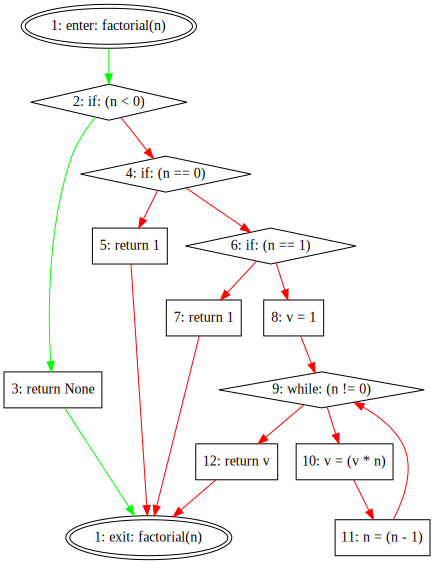

In [85]:
Source(to_graph(gen_cfg(inspect.getsource(factorial)), arcs=cov.arcs()))

Here is another function that gives you the nearest ten's multiplier

In [86]:
def round10(r):
    while r % 10 != 0:
        r += 1
    return r

As before, we execute the function under the `ConcolicTracer` context.

In [87]:
with ConcolicTracer() as _:
    r = _[round10](1)

We verify that we were able to capture all the predicates

In [88]:
_.context

({'round10_r_int_3': 'Int'},
 [0 != round10_r_int_3%10,
  0 != (round10_r_int_3 + 1)%10,
  0 != (round10_r_int_3 + 1 + 1)%10,
  0 != (round10_r_int_3 + 1 + 1 + 1)%10,
  0 != (round10_r_int_3 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_3 + 1 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_3 + 1 + 1 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_3 + 1 + 1 + 1 + 1 + 1 + 1 + 1)%10,
  0 != (round10_r_int_3 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1)%10,
  Not(0 !=
      (round10_r_int_3 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1)%10)])

As before, we use `zeval()` to obtain results.

In [89]:
zeval(_, python=False)

{'round10_r_int_3': '41'}

Does our concolic proxies work across functions? Say we have a function `max_value()` as below.

In [90]:
def abs_value(a):
    if a > 0:
        return a
    else:
        return -a

It is called by another function `abs_max()`

In [91]:
def abs_max(a, b):
    a1 = abs_value(a)
    b1 = abs_value(b)
    if a1 > b1:
        c = a1
    else:
        c = b1
    return c

Using the `Concolic()` context on `abs_max()`.

In [92]:
with ConcolicTracer() as _:
    _[abs_max](2, 1)

As expected, we have the predicates across functions.

In [93]:
_.context

({'abs_max_a_int_4': 'Int', 'abs_max_b_int_5': 'Int'},
 [0 < abs_max_a_int_4, 0 < abs_max_b_int_5, abs_max_a_int_4 > abs_max_b_int_5])

Using negative numbers makes it behave as expected.

In [94]:
with ConcolicTracer() as _:
    _[abs_max](-2, -1)

In [95]:
_.context

({'abs_max_a_int_6': 'Int', 'abs_max_b_int_7': 'Int'},
 [Not(0 < abs_max_a_int_6),
  Not(0 < abs_max_b_int_7),
  -abs_max_a_int_6 > -abs_max_b_int_7])

In [96]:
zeval(_, python=False)

{'abs_max_b_int_7': '0', 'abs_max_a_int_6': ['-', '1']}

#### zstr

Here, we define the wrappers for strings `zstr`. First we define our initialization routines. Since `str` is a primitive type, we define `new` to extend it.

In [97]:
class zstr(str):
    def __new__(cls, context, zn, v):
        return str.__new__(cls, v)

As before, initialization proceeds with `create()` and the constructor.

In [98]:
class zstr(zstr):
    @classmethod
    def create(cls, context, zn, v=None):
        return zproxy_create(cls, 'String', z3.String, context, zn, v)

    def __init__(self, context, z, v=None):
        self.context, self.z, self.v = context, z, v
        self._len = zint(context, z3.Length(z), len(v))

We also define `_zv()` helper to help us with methods that accept another string

In [99]:
class zstr(zstr):
    def _zv(self, o):
        return (o.z, o.v) if isinstance(o, zstr) else (z3.StringVal(o), o)

##### zord
We define `zord` that given a symbolic one character long string, obtains the `ord()` for that. It returns two values. The first one is the variable that corresponds to `ord()`, and second is the predicate that links the variable to the passed in single character string.

In [100]:
def zord(context, c):
    bn = "bitvec_%d" % fresh_name()
    v = z3.BitVec(bn, 8)
    context[0][bn] = 'BitVec'
    z = (z3.Unit(v) == c)
    context[1].append(z)
    return v

We use it as follows

In [101]:
zc = z3.String('arg_%d' % fresh_name())

In [102]:
with ConcolicTracer() as _:
    zi = zord(_.context, zc)

The symbolic bitvector is in `zi`. It is linked to the passed in argument in `context`

In [103]:
_.context

({'bitvec_9': 'BitVec'}, [seq.unit(bitvec_9) == arg_8])

We can specify what the result of `ord()` should be, and call `z3.solve()` to provide us with a solution that will provide the required result.

In [104]:
z3.solve(_.path + [zi == 65])

[arg_8 = "A", bitvec_9 = 65]


##### zchr
Similarly, we can convert the ASCII value back to a single character string using `zchr()`

In [105]:
def zchr(context, i):
    sn = 'string_%d' % fresh_name()
    s = z3.String(sn)
    context[0][sn] = 'String'
    z = z3.And([s == z3.Unit(i), z3.Length(s) == 1])
    context[1].append(z)
    return s

For using it, we first define a bitvector that is 8 bits long.

In [106]:
i = z3.BitVec('bv_%d' % fresh_name(), 8)

We can now retrieve the `chr()` representation as below.

In [107]:
with ConcolicTracer() as _:
    zc = zchr(_.context, i)

In [108]:
_.context

({'string_11': 'String'},
 [And(string_11 == seq.unit(bv_10), str.len(string_11) == 1)])

As before, we can specify what the end result of calling `chr()` should be to get the original argument.

In [109]:
z3.solve(_.path + [zc == z3.StringVal('a')])

[bv_10 = 97, string_11 = "a"]


##### Equality

The equality of `zstr` is defined similar to that of `zint`

In [110]:
class zstr(zstr):
    def __eq__(self, other):
        z, v = self._zv(other)
        return zbool(self.context, self.z == z, self.v == v)

    def __req__(self, other):
        return self.__eq__(other)

The `zstr` class is used as follows.

In [111]:
def tstr1(s):
    if s == 'h':
        return True
    else:
        return False

In [112]:
with ConcolicTracer() as _:
    r = _[tstr1]('h')

In [113]:
_.context

({'tstr1_s_str_12': 'String'}, [tstr1_s_str_12 == "h"])

It works even if we have more than one character.

In [114]:
def tstr1(s):
    if s == 'hello world':
        return True
    else:
        return False

In [115]:
with ConcolicTracer() as _:
    r = _[tstr1]('hello world')

In [116]:
zeval(_, python=False)

{'tstr1_s_str_13': '"hello world"'}

##### Concatenation
What if we need to concatenate two strings? We need additional helpers to accomplish that.

In [117]:
class zstr(zstr):
    def __add__(self, other):
        z, v = self._zv(other)
        return zstr(self.context, self.z + z, self.v + v)

    def __radd__(self, other):
        return self.__add__(other)

Here is how it can be used. First, we create the wrapped arguments

In [118]:
with ConcolicTracer() as _:
    v1, v2 = [zstr.create(_.context, 'arg_%d' % fresh_name(), s)
              for s in ['hello', 'world']]
    if (v1 + ' ' + v2) == 'hello world':
        print('hello world')

hello world


The addition of symbolic variables is preserved in `context`

In [119]:
_.context

({'arg_14': 'String', 'arg_15': 'String'},
 [str.++(str.++(arg_14, " "), arg_15) == "hello world"])

##### Substrings
Similarly, accessing substrings also require extra help.

In [120]:
class zstr(zstr):
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            start, stop, step = idx.indices(len(self.v))
            assert step == 1  # for now
            assert stop >= start  # for now
            rz = z3.SubString(self.z, start, stop - start)
            rv = self.v[idx]
        elif isinstance(idx, int):
            rz = z3.SubString(self.z, idx, 1)
            rv = self.v[idx]
        else:
            assert False  # for now
        return zstr(self.context, rz, rv)

    def __iter__(self):
        return zstr_iterator(self.context, self)

##### Iterator

We define the iterator as follows.

In [121]:
class zstr_iterator():
    def __init__(self, context, zstr):
        self.context = context
        self._zstr = zstr
        self._str_idx = 0
        self._str_max = zstr._len  # intz is not an _int_

    def __next__(self):
        if self._str_idx == self._str_max:  # intz#eq
            raise StopIteration
        c = self._zstr[self._str_idx]
        self._str_idx += 1
        return c

    def __len__(self):
        return self._len

Here is how it can be used.

In [122]:
def tstr2(s):
    if s[0] == 'h' and s[1] == 'e' and s[3] == 'l':
        return True
    else:
        return False

In [123]:
with ConcolicTracer() as _:
    r = _[tstr2]('hello')

In [124]:
_.context

({'tstr2_s_str_16': 'String'},
 [str.substr(tstr2_s_str_16, 0, 1) == "h",
  str.substr(tstr2_s_str_16, 1, 1) == "e",
  str.substr(tstr2_s_str_16, 3, 1) == "l"])

In [125]:
zeval(_, python=False)

{'tstr2_s_str_16': '"he\\x00l"'}

##### upper and lower
A major complication is supporting upper and lower methods.

In [126]:
class zstr(zstr):
    def upper(self):
        empty = ''
        ne = 'empty_%d' % fresh_name()
        result = zstr.create(self.context, ne, empty)
        self.context[1].append(z3.StringVal(empty) == result.z)
        cdiff = (ord('a') - ord('A'))
        for i in self:
            oz = zord(self.context, i.z)
            uz = zchr(self.context, oz - cdiff)
            rz = z3.And([oz >= ord('a'), oz <= ord('z')])
            ov = ord(i.v)
            uv = chr(ov - cdiff)
            rv = ov >= ord('a') and ov <= ord('z')
            if zbool(self.context, rz, rv):
                i = zstr(self.context, uz, uv)
            else:
                i = zstr(self.context, i.z, i.v)
            result += i
        return result

In [127]:
from InformationFlow import make_str_abort_wrapper

In [128]:
for name, fn in inspect.getmembers(str, callable):
    if name in ['__format__', 'format_map', 'format',
                '__mul__', '__rmul__', 'center', 'zfill', 'decode', 'encode']:
        setattr(zstr, name, make_str_abort_wrapper(fn))

Here is how it is used.

In [129]:
def tstr3(s):
    if s.upper() == 'H':
        return True
    else:
        return False

In [130]:
with ConcolicTracer() as _:
    r = _[tstr3]('h')

We can use zeval how.

In [131]:
zeval(_, python=False)

{'tstr3_s_str_17': '"h"'}

Here is a larger example using `upper()`

In [132]:
def tstr4(s):
    if s.upper() == 'HELLO WORLD':
        return True
    else:
        return False

In [133]:
with ConcolicTracer() as _:
    r = _[tstr4]('hello world')

In [134]:
zeval(_, python=False)

{'tstr4_s_str_21': '"hello world"'}

##### startswith
We define `startswith()`.

In [135]:
class zstr(zstr):
    def startswith(self, other, beg=0, end=None):
        assert end is None  # for now
        assert isinstance(beg, int)  # for now
        zb = z3.IntVal(beg)

        others = other if isinstance(other, tuple) else (other, )

        last = False
        for o in others:
            z, v = self._zv(o)
            r = z3.IndexOf(self.z, z, zb)
            last = zbool(self.context, r == zb, self.v.startswith(v))
            if last:
                return last
        return last

##### find
We also define `find()`

In [136]:
class zstr(zstr):
    def find(self, other, beg=0, end=None):
        assert end is None  # for now
        assert isinstance(beg, int)  # for now
        zb = z3.IntVal(beg)
        z, v = self._zv(other)
        zi = z3.IndexOf(self.z, z, zb)
        vi = self.v.find(v, beg, end)
        return zint(self.context, zi, vi)

Using it.

In [137]:
with ConcolicTracer() as _:
    v1 = zstr.create(_.context, 'arg_%d' % fresh_name(), 'hello')
    if v1.find('e') >= 0:
        print('found')

found


In [138]:
_.context

({'arg_45': 'String'}, [Or(0 < str.indexof(arg_45, "e", 0),
     str.indexof(arg_45, "e", 0) == 0)])

In [139]:
z3.solve(_.path)

[arg_45 = "rep"]


### Fuzzing with constraints

We now turn our attention to the DB class from the [chapter on information flow](InformationFlow.ipynb)

In [140]:
from InformationFlow import DB, sample_db, update_inventory

We first populate our database.

In [141]:
from GrammarMiner import VEHICLES

In [142]:
db = sample_db()
for V in VEHICLES:
    inventory_def = db.db['inventory'][0]
    k, v = zip(*inventory_def.items())
    val = [repr(cast(val)) for cast, val in zip(v, V.split(','))]
    db.sql('insert into inventory (%s) values (%s)' % (','.join(k),
                                                          ','.join(val)))

In [143]:
db.db

{'inventory': ({'year': int, 'kind': str, 'company': str, 'model': str},
  [{'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
   {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
   {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}])}

We are now ready to fuzz our `DB` class. Hash functions are difficult to handle directly (because it relies on internal C functions). Hence we modify `table` slightly.

In [144]:
class ConcolicDB(DB):
    def table(self, t_name):
        for k, v in self.db:
            if t_name == k:
                return v
        raise SQLException('Table (%s) was not found' % repr(t_name))

To make it easy, we define a single function `db_select` that directly invokes `db.sql`.

In [145]:
def db_select(s):
    my_db = ConcolicDB()
    my_db.db = [(k, v) for (k, v) in db.db.items()]
    r = my_db.sql(s)
    return r

In [146]:
with ConcolicTracer() as _:
    _[db_select]('select kind from inventory')

The predicates encountered during the execution are as follows

In [147]:
_.path

[str.indexof(db_select_s_str_46, "select ", 0) == 0,
 str.indexof(db_select_s_str_46, "select ", 0) == 0,
 Not(0 >
     str.indexof(str.substr(db_select_s_str_46, 7, 19),
                 " from ",
                 0)),
 Not(19 <
     str.indexof(str.substr(db_select_s_str_46, 7, 19),
                 " from ",
                 0)),
 Or(0 <
    str.indexof(str.substr(db_select_s_str_46, 7, 19),
                " from ",
                0),
    str.indexof(str.substr(db_select_s_str_46, 7, 19),
                " from ",
                0) ==
    0),
 Not(Or(0 <
        str.indexof(str.substr(db_select_s_str_46, 7, 19),
                    " where ",
                    0),
        str.indexof(str.substr(db_select_s_str_46, 7, 19),
                    " where ",
                    0) ==
        0)),
 Not(19 <
     str.indexof(str.substr(db_select_s_str_46, 7, 19),
                 " from ",
                 0) +
     6),
 Or(19 >
    str.indexof(str.substr(db_select_s_str_46, 7, 19),
  

We can try to solve the predicates obtained.

__Note:__ Due to the state of the _theory of strings_ in SMT Solvers, it is possible that you might get _unknown_ when executing the `zeval()` below. This is perfectly fine. It just means that the SMT solver gave up before it reached an answer.

In [148]:
zeval(_, python=False, log=True)

unknown
(error "line 32 column 10: model is not available")


#### CGrammarFuzzer

The concolic framework can be used directly in fuzzing. First, we extend our `TaintedGrammarFuzzer` with a few helper methods.

In [149]:
from InformationFlow import TaintedGrammarFuzzer, INVENTORY_GRAMMAR, ostr, SQLException

In [150]:
class CGrammarFuzzer(TaintedGrammarFuzzer):
    def tree_to_string(self, tree):
        symbol, children, *_ = tree
        e = ostr('')
        if children:
            return e.join([self.tree_to_string(c) for c in children])
        else:
            return e if symbol in self.grammar else symbol

    def prune_tree(self, tree, tokens):
        name, children = tree
        children = self.coalesce(children)
        if name in tokens:
            return (name, [(self.tree_to_string(tree), [])])
        else:
            return (name, [self.prune_tree(c, tokens) for c in children])

    def coalesce(self, children):
        last = ostr('')
        new_lst = []
        for cn, cc in children:
            if cn not in self.grammar:
                last += cn
            else:
                if last:
                    new_lst.append((last, []))
                    last = ostr('')
                new_lst.append((cn, cc))
        if last:
            new_lst.append((last, []))
        return new_lst

We can now use the fuzzer to produce inputs for our DB.

In [151]:
from ExpectError import ExpectError

In [152]:
tgf = CGrammarFuzzer(INVENTORY_GRAMMAR)
qtree = tgf.fuzz_tree()
query = tgf.tree_to_string(qtree)

with ExpectError():
    print(repr(query))
    with ConcolicTracer() as _:
        res = _[db_select](str(query))
    print(repr(res))

'select (k) from y'


Traceback (most recent call last):
  File "<ipython-input-152-fd3da37d97ba>", line 8, in <module>
    res = _[db_select](str(query))
  File "<ipython-input-30-635d2b1b13c2>", line 3, in __call__
    self.result = self.fn(*self.concolic(args))
  File "<ipython-input-145-26b52b86ed9e>", line 4, in db_select
    r = my_db.sql(s)
  File "<string>", line 18, in sql
  File "<string>", line 17, in do_select
  File "<ipython-input-144-3c207d1c78ac>", line 6, in table
    raise SQLException('Table (%s) was not found' % repr(t_name))
InformationFlow.SQLException: Table ('y') was not found (expected)


Our fuzzer returns with an exception. It is unable to find the specified table. Let us examine the predicates it encountered.

In [153]:
for i, p in enumerate(_.path):
    print(i, p)

0 str.indexof(db_select_s_str_47, "select ", 0) == 0
1 str.indexof(db_select_s_str_47, "select ", 0) == 0
2 Not(0 >
    str.indexof(str.substr(db_select_s_str_47, 7, 10),
                " from ",
                0))
3 Not(10 <
    str.indexof(str.substr(db_select_s_str_47, 7, 10),
                " from ",
                0))
4 Or(0 <
   str.indexof(str.substr(db_select_s_str_47, 7, 10),
               " from ",
               0),
   str.indexof(str.substr(db_select_s_str_47, 7, 10),
               " from ",
               0) ==
   0)
5 Not(Or(0 <
       str.indexof(str.substr(db_select_s_str_47, 7, 10),
                   " where ",
                   0),
       str.indexof(str.substr(db_select_s_str_47, 7, 10),
                   " where ",
                   0) ==
       0))
6 Not(10 <
    str.indexof(str.substr(db_select_s_str_47, 7, 10),
                " from ",
                0) +
    6)
7 Or(10 >
   str.indexof(str.substr(db_select_s_str_47, 7, 10),
               " from ",
 

Note that we can obtain constraints that are not present in the grammar from using the `ConcolicTracer`. In particular, see how we are able to obtain the condition that the table needs to be `inventory` (8) for the fuzzing to succeed.

How do we lift these to the grammar? and in particular how do we do it automatically? One option we have is to simply switch the last predicate obtained. In our case, the last predicate is (6). Can we simply invert the predicate and solve it again?

In [154]:
new_path = _.path[0:-1] + [z3.Not(_.path[-1])]

In [155]:
new_ = ConcolicTracer((_.decls, new_path))
new_.fn = _.fn
new_.fn_args = _.fn_args

In [156]:
zeval(new_, python=False, log=True)

unsat
(error "line 32 column 10: model is not available")


Indeed, this will not work as the string lengths being compared to are different.

In [157]:
print(_.path[-1])
z3.solve(z3.Not(_.path[-1]))

Not(str.substr(str.substr(db_select_s_str_47, 7, 10), 9, 1) ==
    "inventory")
no solution


A better idea is to investigate what _string_ comparisons are being made, and associate that with the corresponding nodes in the grammar. Let us examine our derivation tree (pruned to avoid recursive structures, and to focus on important parts).

In [158]:
dt = tgf.prune_tree(qtree, ['<assignments>', '<names>',
                            '<literals>', '<exprs>', '<bexpr>', '<table>'])
dt

('<start>',
 [('<query>',
   [('select ', []),
    ('<exprs>', [('(k)', [])]),
    (' from ', []),
    ('<table>', [('y', [])])])])

Can we identify which part of the input was supplied by which part of the grammar? We define `span()` that can recover this information from the derivation tree.

In [159]:
from GrammarFuzzer import START_SYMBOL

In [160]:
def span(node, g, node_start=0):
    hm = {}
    k, cs = node
    end_i = node_start
    new_cs = []
    for c in cs:
        chm, (ck, child_start, child_end, gcs) = span(c, g, end_i)
        new_cs.append((ck, child_start, child_end, gcs))
        end_i = child_end
        hm.update(chm)
    node_end = end_i if cs else node_start + len(k)
    if k in g and k != START_SYMBOL:
        hm[k] = (node_start, node_end - node_start)
    return hm, (k, node_start, node_end, new_cs)

We use it as follows

In [161]:
span_hm, _n = span(dt, INVENTORY_GRAMMAR)

In [162]:
span_hm

{'<exprs>': (7, 3), '<table>': (16, 1), '<query>': (0, 17)}

We can check if we got the right values as follows.

In [163]:
print("query:", query)
for k in span_hm:
    start, l = span_hm[k]
    print(k, query[start:start + l])

query: select (k) from y
<exprs> (k)
<table> y
<query> select (k) from y


Next, we need to obtain all the comparisons made in each predicate. For that, we define two helper functions. The first is `unwrap_substrings()` that translates multiple calls to `z3.SubString` and returns the start, and length of the given z3 string expression.

In [164]:
def unwrap_substrings(s):
    assert s.decl().name() == 'str.substr'
    cs, frm, l = s.children()
    if cs.decl().name() == 'str.substr':
        newfrm, _l = unwrap_substrings(cs)
        return (frm.as_long() + newfrm, l.as_long())
    else:
        return (frm.as_long(), l.as_long())

We define `traverse_z3()` that traverses a given z3 string expression, and collects all direct string comparisons to a substring of the original argument.

In [165]:
def traverse_z3(p, hm):
    n = p.decl().name()
    if n == 'not':
        return traverse_z3(p.children()[0], hm)
    elif n == '=':
        i, j = p.children()
        if isinstance(i, (int, z3.IntNumRef)):
            return traverse_z3(j, hm)
        elif isinstance(j, (int, z3.IntNumRef)):
            return traverse_z3(i, hm)
        else:
            if i.is_string() and j.is_string():
                if i.is_string_value():
                    hm[i.as_string()] = unwrap_substrings(j)
                elif j.is_string_value():
                    hm[j.as_string()] = unwrap_substrings(i)
            else:
                assert False  # for now
    elif n == '<' or n == '>':
        i, j = p.children()
        if isinstance(i, (int, z3.IntNumRef)):
            return traverse_z3(j, hm)
        elif isinstance(j, (int, z3.IntNumRef)):
            return traverse_z3(i, hm)
        else:
            assert False
    return p

In [166]:
comparisons = {}
for p in _.path:
    traverse_z3(p, comparisons)
comparisons

{'"inventory"': (16, 1)}

All that we need now is to declare string variables that match the substrings in `comparisons`, and solve for them for each item in the path. For that, we define `find_alternatives()`.

In [167]:
def find_alternatives(spans, cmp):
    alts = {}
    for key in spans:
        start, l = spans[key]
        rset = set(range(start, start + l))
        for ckey in cmp:
            cstart, cl = cmp[ckey]
            cset = set(range(cstart, cstart + cl))
            # if rset.issubset(cset): <- ignoring subsets for now.
            if rset == cset:
                if key not in alts:
                    alts[key] = set()
                alts[key].add(ckey)
    return alts

We use it as follows.

In [168]:
alternatives = find_alternatives(span_hm, comparisons)
alternatives

{'<table>': {'"inventory"'}}

So, we have our alternatives for each key in the grammar. We can now update our grammar as follows.

In [169]:
INVENTORY_GRAMMAR_NEW = dict(INVENTORY_GRAMMAR)

In [170]:
for k in alternatives:
    INVENTORY_GRAMMAR_NEW[k] = INVENTORY_GRAMMAR_NEW[k] + list(alternatives[k])

We made a choice here. We could have completely overwritten the definition of `<table>` . Instead, we added our new alternatives to the existing definition. This way, our fuzzer will also attempt other values for `<table>` once in a while.

In [171]:
INVENTORY_GRAMMAR_NEW['<table>']

['<word>', '"inventory"']

Let us try fuzzing with our new grammar.

In [172]:
with ExpectError():
    try:
        gf = CGrammarFuzzer(INVENTORY_GRAMMAR_NEW)
        qtree = gf.fuzz_tree()
        query = ostr(gf.tree_to_string(qtree))
        print(repr(query))
        with ConcolicTracer() as _:
            res = _[db_select](str(query))
        print(repr(res))
    except SQLException as e:
        print(e)

'select 3!=((((Z)==f!=H==-2!=t==(((0)!=1!=1))!=((-2)==((((4!=----2!=5==(1))))))))) from "inventory"'
Table ('"inventory"') was not found


That is, we were able to reach the dangerous method `my_eval()`.
In effect, what we have done is to lift parts of predicates to the grammar. The new grammar can generate inputs that reach deeper into the program than before. Note that we have only handled the equality predicate. One can also lift the '<' and '>' comparison operators to the grammar if required.

### Limitations

As with dynamic taint analysis, implicit control flow can obscure the predicates encountered during concolic execution. Similarly, calls to internal C functions can cause the symbolic information to be discarded, and only partial information may be obtained.

## Lessons Learned

* String-based and character-based taints allow to dynamically track the information flow form input to the internals of a system and back to the output.

* Checking taints allows to discover untrusted inputs and information leakage at runtime.

* Data conversions and implicit data flow may strip taint information; the resulting untainted strings should be treated as having the worst possible taint.

* Taints can be used in conjunction with fuzzing to provide a more robust indication of incorrect behavior than to simply rely on program crashes.

* Concolic execution can often provide more information than taint analysis with respect to the program behavior. However, this comes at a much larger runtime cost. Hence, unlike taint analysis, real-time analysis is often not possible.

* Similar to taint analysis, concolic execution also suffers from limitations such as indirect control flow and internal function calls.

* Predicates from concolic execution can be used in conjunction with fuzzing to provide an even more robust indication of incorrect behavior than taints, and can be used to create grammars that are better at producing valid inputs.

## Next Steps

A costlier but stronger alternative to concolic fuzzing is [symbolic fuzzing](SymbolicFuzzer.ipynb). Similarly, [search based fuzzing](SearchBasedFuzzer.ipynb) can often provide a cheaper exploration strategy than relying on SMT solvers to provide inputs slightly different from the current path. The chapter on [oracles](Oracles.ipynb) discusses how to provide better oracles in detail.

## Background

Taint analysis on Python using a library approach as we implemented in this chapter was discussed by Conti et al. \cite{Conti2010}. The concolic execution technique used in this chapter was pioneered by PeerCheck \cite{PeerCheck}, and Python Error Finder \cite{Barsotti2018}.

## Exercises

For example, say we want to compute the binomial coefficient by the following formulas

$$ 
^nP_k=\frac{n!}{(n-k)!}
$$

$$
\binom nk=\,^nC_k=\frac{^nP_k}{k!}
$$


In [173]:
def factorial(n):
    v = 1
    while n != 0:
        v = v * n
        n -= 1
    return v


def permutation(n, k):
    return factorial(n) / factorial(n - k)


def combination(n, k):
    return permutation(n, k) / factorial(k)


def binomial(n, k):
    if n < 0 or k < 0 or n < k:
        raise Exception('Invalid values')
    return combination(n, k)

In [174]:
binomial(4, 2)

6.0